In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yfinance as yf
from pandas_datareader import data as pdr
import requests
import datetime
import io
import os, contextlib
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

## Data fetching

In [2]:
#Fetch the stocks we are interested 
tickers = ['IYM', 'IYK','IYE','IYG','IYH','IYJ','IYW','IYZ','IDU']

data = pdr.DataReader(tickers, data_source='yahoo', start='2019-01-01', end='2021-06-22')

data = data['Close']

data.rename(columns={"IYM": "Basic Materials", "IYK": "Consumer Goods", "IYE": "Energy", "IYG": "Financial Services", "IYH": "Healthcare", "IYJ": "Industrial", "IYW":"Technology", "IYZ": "Telecommunications", "IDU": "Utilities"},inplace=True)

data.to_csv('data_close.csv')

data.head()

Symbols     Basic Materials  Consumer Goods     Energy  Financial Services  \
Date                                                                         
2019-01-02        84.570000      106.209999  31.820000          113.730003   
2019-01-03        82.059998      104.870003  31.510000          111.550003   
2019-01-04        85.440002      107.809998  32.669998          115.690002   
2019-01-07        85.559998      108.269997  33.180000          116.180000   
2019-01-08        86.610001      109.580002  33.480000          116.400002   

Symbols     Healthcare  Industrial  Technology  Telecommunications  Utilities  
Date                                                                           
2019-01-02  178.330002   64.415001   40.070000           26.549999  65.820000  
2019-01-03  174.360001   62.560001   38.215000           26.139999  65.930000  
2019-01-04  179.830002   64.934998   39.952499           26.940001  66.885002  
2019-01-07  181.240005   65.394997   40.290001           27.320000  66.449997  
2019-01-08  183.080002   66.449997   40.737499           27.740000  67.290001

In [3]:
#Create plot of the ETFs prices
import plotly.express as px

px.line(data,width=1280,height=720,title='ETF price')



In [4]:
#Create everage of all ETFs
data_average = data.mean(axis=1)

px.line(data_average,width=1280,height=720,title='Averaged ETFs prices')

In [5]:
#Plot mean in addition with a few stock prices
data['Average'] = data.mean(axis=1)

px.line(data,y=['Technology','Healthcare','Utilities','Average'],title='Comparison between ETFs and the average',width=1280,height=720)

In [6]:
#Plot the graph of returns
change = data.pct_change()

change.drop(columns='Average',inplace=True)

px.line(change, title='Returns of ETFs',width=1280,height=720)

In [7]:
#Plot histograms of pct_change (returns)
for i in change.columns:
    plt.figure()
    fig = px.histogram(change[i],nbins=100)
    fig.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
#Plot the cumulative returns
fig = plt.figure()
cumsum = ((change + 1).cumprod() -1)
px.line(cumsum,width=1280,height=720,title='Cumulative returns of ETFs')

<Figure size 432x288 with 0 Axes>

In [9]:
#Compute traling volatility for all ETFs (60 days window)
volatility = change.rolling(window=60).std()*np.sqrt(60)
px.line(volatility,title='Trailing volatility - 60 days window',width=1280,height=720)

In [10]:
#Compute annualized volatility for all ETFs
ann_vol = change.std()*np.sqrt(252)
ann_vol = pd.DataFrame(ann_vol)
ann_vol.rename(columns={0:'Volatility'},inplace=True)
ann_vol.reset_index(inplace=True)
ann_vol.sort_values('Volatility',inplace=True)
px.bar(ann_vol,x='Symbols',y='Volatility',width=1280,height=720,title='Annualized volatility')

In [11]:
#Create new dataframes (for the selected ETFs) in order to perform forecasting
sectors = ['Technology','Healthcare','Utilities']

dfs = []

def create_df():
    for u in sectors:
        d = pd.DataFrame(data.loc[:,u])
        d.reset_index(inplace=True)
        d.rename(columns={'Date':'ds',u:'y'},inplace=True)
        dfs.append(d)

create_df()

#Create the separated dataframes from the list
technology = dfs[0]
healthcare = dfs[1]
utilities = dfs[2]

In [14]:
#Use facebook prophet API (80% confidence interval)

def fbprophet(data):
    m = Prophet()
    m.fit(data)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    fig1 = plot_plotly(m,forecast,figsize=(1280,720))
    fig1.show()
    fig2 = plot_components_plotly(m,forecast)
    fig2.show()
    fig = m.plot(forecast)
    delta = add_changepoints_to_plot(fig.gca(),m,forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


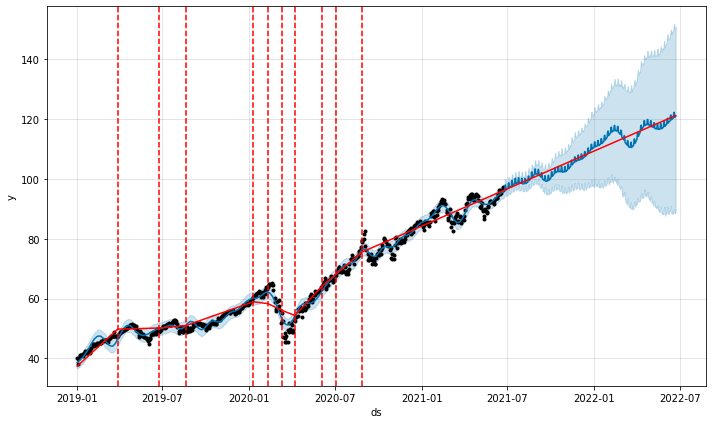

In [15]:
#Forecasting for technology ETF
fbprophet(technology)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


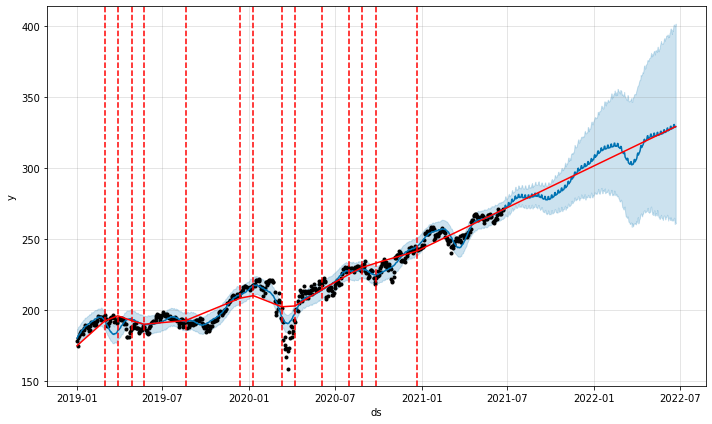

In [301]:
#Forecasting for healthcare ETF
fbprophet(healthcare)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


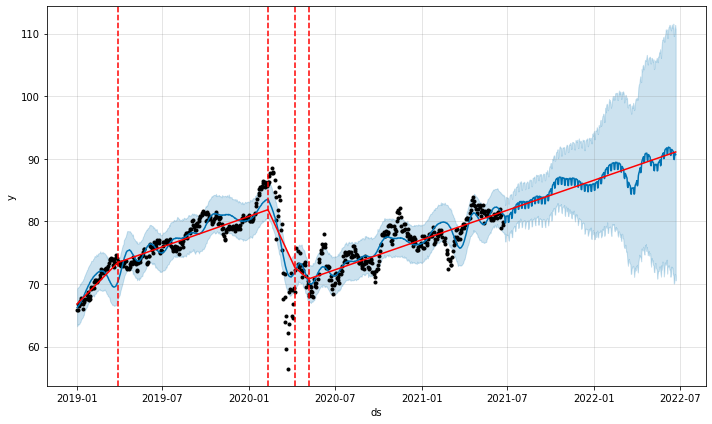

In [302]:
#Forecasting for utilities ETF
fbprophet(utilities)

In [31]:
'''
#Use facebook prophet API (80% confidence interval)

#Create the model
m = Prophet()
m.fit(healthcare)

#Create future datapoints (dates)
future = m.make_future_dataframe(periods=365)
future.tail()

#Perform forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = plot_plotly(m,forecast)

fig1.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
'''
#Plot components
fig2 = plot_components_plotly(m,forecast)
fig2.show()

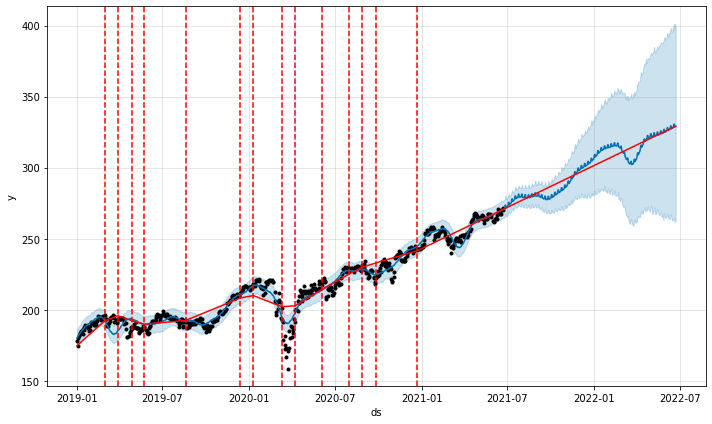

In [32]:
'''
#Plot the changing points
fig = m.plot(forecast)
delta = add_changepoints_to_plot(fig.gca(),m,forecast)

## ----------------------------------------------------------------